In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Some helper functions

In [2]:
def wrap_function(phi):
    """Computes the wrap function elementwise for the input array.
    """

    return ( (phi + np.pi) % (2*np.pi) ) - np.pi

# Set up test data

Linear phase.

In [3]:
N = 40
phi = np.linspace(0, 9*np.pi, N) + (3*np.pi) + 3
phi[20:] += 2.0
phi[30:] += 5.0
grid = np.linspace(0,1,N)

psi = wrap_function(phi)

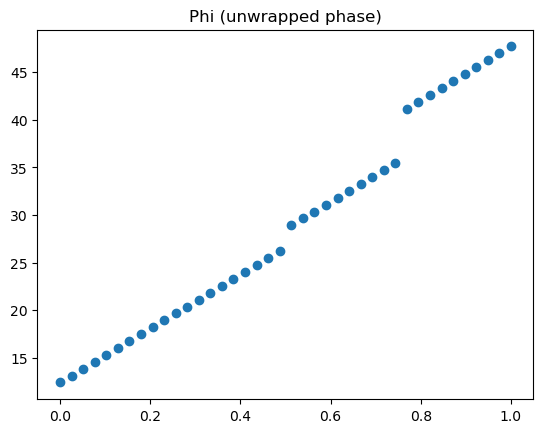

In [4]:
plt.scatter(grid, phi)
plt.title("Phi (unwrapped phase)")
plt.show()

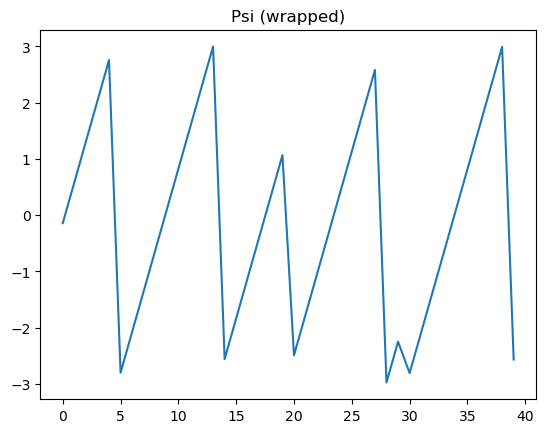

In [6]:
plt.plot(psi)
plt.title("Psi (wrapped)")
plt.show()

# Differencing matrix

In [29]:
# Build F mat
F = np.eye(N)
np.fill_diagonal(F[1:], -1)
F = F[1:,:]


In [30]:
F.shape
print(F)

[[-1.  1.  0. ...  0.  0.  0.]
 [ 0. -1.  1. ...  0.  0.  0.]
 [ 0.  0. -1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  1.  0.  0.]
 [ 0.  0.  0. ... -1.  1.  0.]
 [ 0.  0.  0. ...  0. -1.  1.]]


In [31]:
phi_diffs = F @ phi
psi_diffs = F @ psi
psi_diffs_wrapped = wrap_function(psi_diffs)

# Simple 1D recovery?

In [32]:
# Make $\phi_1$
phi1 = np.zeros(N)
phi1[0] = psi[0]

# Build the undersampling matrix
P = np.eye(N)[1:,:].T

# Set initial weights
weights = np.ones(F.shape[0])

# rhs vector
rhs = P.T @ F.T @ np.diag(weights) @ ( wrap_function(F @ psi) - (F @ phi1) )

# Q matrix
Q = P.T @ F.T @ np.diag(weights) @ F @ P 

# Solve system for answer
phi2 = np.linalg.solve(Q, rhs)

# Append first entry
reconstructed_phi = np.zeros(N)
reconstructed_phi[1:] = phi2
reconstructed_phi[0] = psi[0]

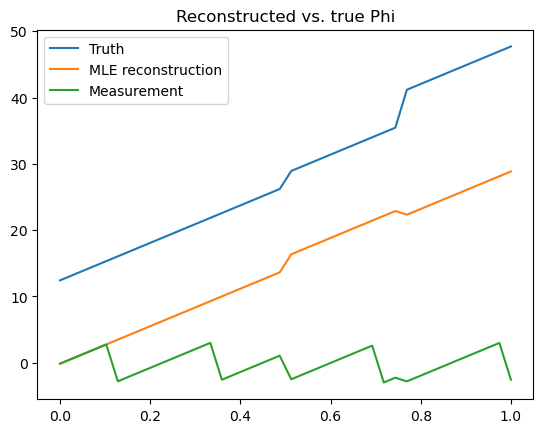

In [33]:
plt.plot(grid, phi, label="Truth")
plt.plot(grid, reconstructed_phi, label="MLE reconstruction")
plt.plot(grid, psi, label="Measurement")
plt.title("Reconstructed vs. true Phi")
plt.legend()
plt.show()

# Function for doing MLE in 1D

In [34]:
def solve_D2_MLE_1D(psi, weights=None):
    """Given a 1D wrapped phase vector psi, computes the MLE estimator corresponding to the D2 data fidelity term."""

    # Figure out shape
    n = len(psi)

    # Build F matrix
    F = np.eye(n)
    np.fill_diagonal(F[1:], -1)
    F = F[1:,:]

    # 
    # Make $\phi_1$
    phi1 = np.zeros(N)
    phi1[0] = psi[0]

    # Build the undersampling matrix
    P = np.eye(N)[1:,:].T

    # Set initial weights
    if weights is None:
        weights = np.ones(F.shape[0])
    else:
        assert len(weights) == len(psi)-1, "psi and weight vector must have same length!"

    # rhs vector
    rhs = P.T @ F.T @ np.diag(weights) @ ( wrap_function(F @ psi) - (F @ phi1) )

    # Q matrix
    Q = P.T @ F.T @ np.diag(weights) @ F @ P  

    # Solve system for answer
    phi2 = np.linalg.solve(Q, rhs)

    # Append first entry
    reconstructed_phi = np.zeros(N)
    reconstructed_phi[1:] = phi2
    reconstructed_phi[0] = psi[0]

    return reconstructed_phi
    

In [37]:
weights = np.ones(len(psi)-1)
reconstructed_phi = solve_D2_MLE_1D(psi, weights=weights)

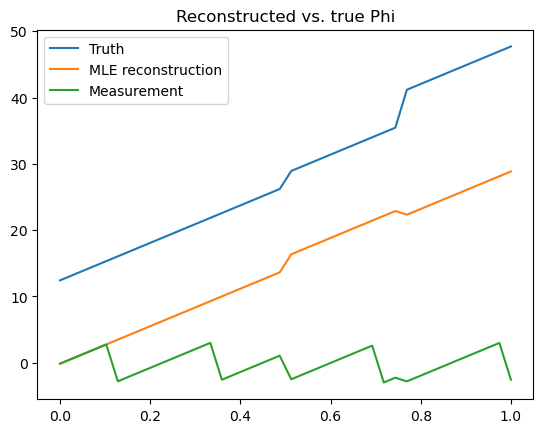

In [38]:

plt.plot(grid, phi, label="Truth")
plt.plot(grid, reconstructed_phi, label="MLE reconstruction")
plt.title("Reconstructed vs. true Phi")
plt.plot(grid, psi, label="Measurement")
plt.legend()
plt.show()

# Modified with IAS?

In [58]:
# Parameters
n_iterations = 100

r = -1 # DO NOT CHANGE THIS
s = 1
vartheta = 1e-2
eta = r*s - 1.5
eta = -1*eta

# Initialize
np.random.seed(0)
weights = np.random.uniform(low=0.1, high=5, size=len(psi)-1) # np.ones(len(psi)-1)
reconstructed_phi = solve_D2_MLE_1D(psi, weights=weights)

# We also need a copy of F
F = np.eye(len(psi))
np.fill_diagonal(F[1:], -1)
F = F[1:,:]

for j in range(n_iterations):

    # Update weights
    weights = (  vartheta + 0.5*( (F @ reconstructed_phi)**2)  )/eta

    # Update phi
    reconstructed_phi = solve_D2_MLE_1D(psi, weights=weights)

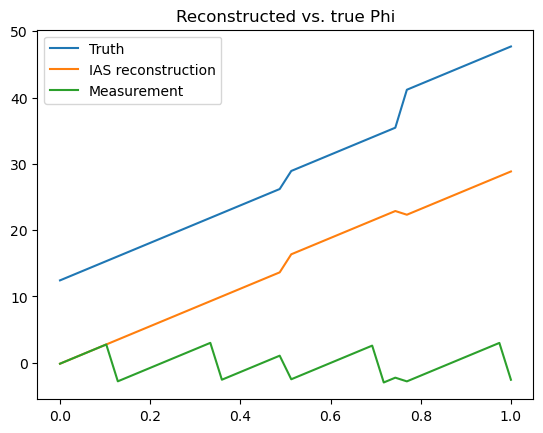

In [59]:
plt.plot(grid, phi, label="Truth")
plt.plot(grid, reconstructed_phi, label="IAS reconstruction")
plt.title("Reconstructed vs. true Phi")
plt.plot(grid, psi, label="Measurement")
plt.legend()
plt.show()

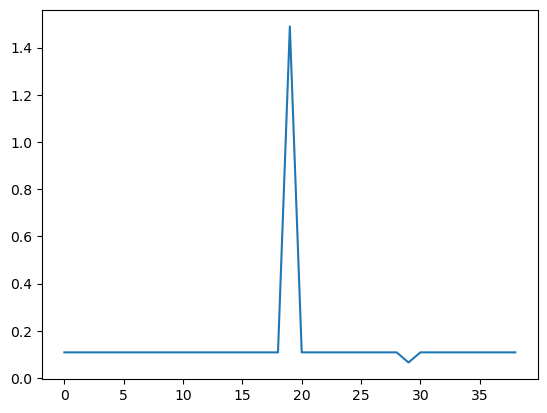

In [60]:
plt.plot(weights)
plt.show()

In [61]:
reconstructed_phi - solve_D2_MLE_1D(psi, weights=None)

array([ 0.00000000e+00,  1.88737914e-15,  3.99680289e-15,  6.21724894e-15,
        8.43769499e-15,  1.02140518e-14,  1.24344979e-14,  1.68753900e-14,
        1.95399252e-14,  2.39808173e-14,  2.66453526e-14,  2.84217094e-14,
        3.19744231e-14,  3.55271368e-14,  4.08562073e-14,  4.26325641e-14,
        4.79616347e-14,  4.97379915e-14,  4.79616347e-14,  4.44089210e-14,
        5.32907052e-14,  4.26325641e-14,  2.84217094e-14,  1.42108547e-14,
        0.00000000e+00, -1.06581410e-14, -1.77635684e-14, -3.19744231e-14,
       -4.26325641e-14, -5.32907052e-14, -7.46069873e-14, -8.88178420e-14,
       -1.10134124e-13, -1.27897692e-13, -1.45661261e-13, -1.63424829e-13,
       -1.70530257e-13, -1.81188398e-13, -1.77635684e-13, -1.81188398e-13])

# Weight adaptation from the paper

In [47]:
# Parameters
n_iterations = 100
e_max = 100
e_min = 1/e_max

# Initialize
#np.random.seed(0)
#weights = np.random.uniform(low=0.1, high=100, size=len(psi)-1) 

weights = e_min*np.ones(len(psi)-1)
weights[19] = 20
weights[29] = 20
#weights = np.ones(len(psi)-1)
reconstructed_phi = solve_D2_MLE_1D(psi, weights=weights)

# We also need a copy of F
F = np.eye(len(psi))
np.fill_diagonal(F[1:], -1)
F = F[1:,:]

for j in range(n_iterations):

    # Update weights
    current_eps = (F @ reconstructed_phi) - wrap_function(F @ psi)

    new_weights = np.zeros(len(weights))
    for i in range(len(weights)):
        if (np.abs(current_eps[i]) <= e_max) and (np.abs(current_eps[i]) >= e_min):
            new_weights[i] = 1.0/np.abs(current_eps[i])
            print("hi")
        elif np.abs(current_eps[i]) > e_max:
            new_weights[i] = 1.0/e_max
        else:
            new_weights[i] = 1.0/e_min

    weights = new_weights.copy()

    # Update phi
    reconstructed_phi = solve_D2_MLE_1D(psi, weights=weights)

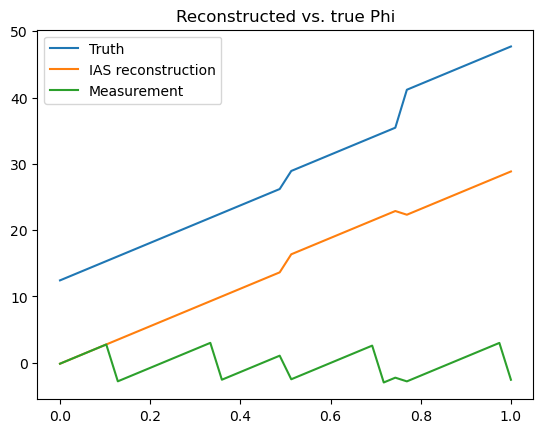

In [48]:
plt.plot(grid, phi, label="Truth")
plt.plot(grid, reconstructed_phi, label="IAS reconstruction")
plt.title("Reconstructed vs. true Phi")
plt.plot(grid, psi, label="Measurement")
plt.legend()
plt.show()

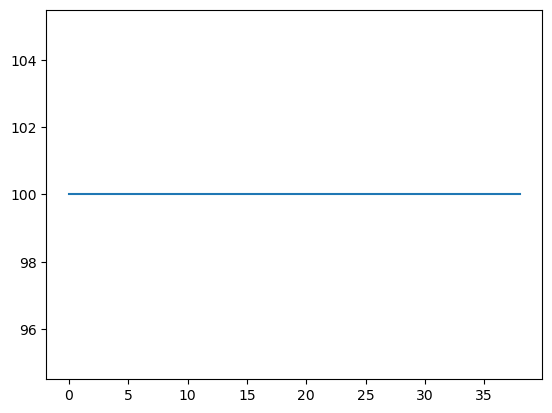

In [49]:
plt.plot(weights)
plt.show()